In [372]:
import pandas as pd
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

import numpy as np
import json
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.geocoders import GoogleV3
from geopy.extra.rate_limiter import RateLimiter 

import requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from urllib.request import urlopen

from bs4 import BeautifulSoup

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import folium


print('Libraries imported.')

Libraries imported.


## I - List of Most Visited Cities

#### We extract the list of most visited cities from Wikipedia. This list is based on data from Euromonitor and  Mastercard.

In [2]:
# Parsing with BeautifulSoup
url ='https://en.wikipedia.org/wiki/List_of_cities_by_international_visitors'
html = urlopen(url)
soup=BeautifulSoup(html,'lxml')
type (soup)

bs4.BeautifulSoup

In [3]:
# Converting data to dataframe
dfs = pd.read_html(str(soup))
df=dfs[0]
df.shape

(140, 8)

In [5]:
df.head()

,Rank(Euromonitor),Rank(Mastercard),City,Country,Arrivals 2018(Euromonitor),Arrivals 2016(Mastercard),Growthin arrivals(Euromonitor),Income(billions $)(Mastercard)
0,1.0,11.0,Hong Kong,"Hong Kong, China",29262700.0,8370000.0,5.0%,6.84
1,2.0,1.0,Bangkok,Thailand,24177500.0,21470000.0,7.7%,14.84
2,3.0,2.0,London,United Kingdom,19233000.0,19880000.0,−3.0%,19.76
3,4.0,NaN,Macau,Macau,18931400.0,NaN,9.2%,NaN
4,5.0,6.0,Singapore,Singapore,18551200.0,12110000.0,5.3%,12.54


In [6]:
# Dropping irrelevant columns and combining 'City' and 'Country' columns
df_city=pd.DataFrame((', '.join(i) for i in zip(df['City'],df['Country'])),columns=['City'])
df_city.head()

,City
0,"Hong Kong, Hong Kong, China"
1,"Bangkok, Thailand"
2,"London, United Kingdom"
3,"Macau, Macau"
4,"Singapore, Singapore"


In [7]:
df_city.describe()

,City
count,140
unique,140
top,"Stockholm, Sweden"
freq,1


## II- Getting Geographical Coordinates

In [9]:
geolocator = Nominatim(user_agent='explorateur_mondial')
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1) #adding 1 second delay between geocoding calls
df_city['Location']=df_city['City'].apply(geocode)

In [373]:
df_location=df_city.copy(deep=True) # Creating copy of dataframe to protect original data

In [374]:
df_location.head()

,City,Location
0,"Hong Kong, Hong Kong, China","(香港 Hong Kong, 中西區 Central and Western Distric..."
1,"Bangkok, Thailand","(กรุงเทพมหานคร, ประเทศไทย, (13.7538929, 100.81..."
2,"London, United Kingdom","(London, Greater London, England, SW1A 2DX, Un..."
3,"Macau, Macau","(Macau, Microrregião de Macau, Mesorregião Cen..."
4,"Singapore, Singapore","(Singapore, (1.357107, 103.8194992))"


In [375]:
# The latitudes and longitudes are stored in the 'Location' column
df_location.iloc[2,1]

Location(London, Greater London, England, SW1A 2DX, United Kingdom, (51.5073219, -0.1276474, 0.0))

In [376]:
# Extracting the latitude and longitude values
df_location['Point'] = df_location['Location'].apply(lambda loc: tuple(loc.point) if loc else None)
df_location['Latitude']=df_location['Point'].apply(lambda x: x[0])
df_location['Longitude']=df_location['Point'].apply(lambda x: x[1])
df_location.head()

,City,Location,Point,Latitude,Longitude
0,"Hong Kong, Hong Kong, China","(香港 Hong Kong, 中西區 Central and Western Distric...","(22.2793278, 114.1628131, 0.0)",22.279328,114.162813
1,"Bangkok, Thailand","(กรุงเทพมหานคร, ประเทศไทย, (13.7538929, 100.81...","(13.7538929, 100.8160803, 0.0)",13.753893,100.816080
2,"London, United Kingdom","(London, Greater London, England, SW1A 2DX, Un...","(51.5073219, -0.1276474, 0.0)",51.507322,-0.127647
3,"Macau, Macau","(Macau, Microrregião de Macau, Mesorregião Cen...","(-5.1133665, -36.6349957, 0.0)",-5.113366,-36.634996
4,"Singapore, Singapore","(Singapore, (1.357107, 103.8194992))","(1.357107, 103.8194992, 0.0)",1.357107,103.819499


In [377]:
# Dropping irrelevant columns
df_location.drop(columns=['Location','Point'],inplace=True)
df_location.head()

,City,Latitude,Longitude
0,"Hong Kong, Hong Kong, China",22.279328,114.162813
1,"Bangkok, Thailand",13.753893,100.816080
2,"London, United Kingdom",51.507322,-0.127647
3,"Macau, Macau",-5.113366,-36.634996
4,"Singapore, Singapore",1.357107,103.819499


## III - Obtaining Foursquare data

In [81]:
CLIENT_ID = '' # Foursquare ID
CLIENT_SECRET = '' # Foursquare Secret
VERSION = '20200120' # Foursquare API version as of January 20, 2020

In [379]:
# Getting venue information and storing results in new column of df_location 
cat_list=[]
def get_venues(row):
    LIMIT=100
    latitude=row['Latitude']
    longitude=row['Longitude']
    venues_url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    LIMIT) # Foursquare API call that returns venue information around specified location 
    venues_results = requests.get(venues_url).json()
    venues=venues_results['response']['groups'][0]['items'] # Accessing 'items' key that contains venue categories
    df_venues=json_normalize(venues) # Creating dataframe from venue information
    cat_list=df_venues['venue.categories'].tolist() # Creating nested lists containing venue categories
    return cat_list

df_location['venues']=df_location.apply(get_venues, axis=1)

In [380]:
df_location_venues=df_location.copy(deep=True) # Creating copy of dataframe to protect original data
df_location_venues.head()

,City,Latitude,Longitude,venues
0,"Hong Kong, Hong Kong, China",22.279328,114.162813,"[[{'id': '4bf58dd8d48988d163941735', 'name': '..."
1,"Bangkok, Thailand",13.753893,100.816080,"[[{'id': '4bf58dd8d48988d1e0931735', 'name': '..."
2,"London, United Kingdom",51.507322,-0.127647,"[[{'id': '4bf58dd8d48988d18f941735', 'name': '..."
3,"Macau, Macau",-5.113366,-36.634996,"[[{'id': '5294c7523cf9994f4e043a62', 'name': '..."
4,"Singapore, Singapore",1.357107,103.819499,"[[{'id': '4bf58dd8d48988d16d941735', 'name': '..."


In [381]:
df_location_venues.iloc[2,3][0] #the venue categories are stored in nested dictionaries in the 'venues' column

[{'id': '4bf58dd8d48988d18f941735',
  'name': 'Art Museum',
  'pluralName': 'Art Museums',
  'shortName': 'Art Museum',
  'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/museum_art_',
   'suffix': '.png'},
  'primary': True}]

In [382]:
# get a list of categories by city and store results in new column of df_location_venues:
def get_category(X):
    categories_list=[]
    if len(X) == 0:
        return None
    else:
        for i in X:
            cat=i[0]['name']
            categories_list.append(cat)
    return categories_list
df_location_venues['Categories']=df_location_venues['venues'].apply(get_category)
df_location_venues.head()

,City,Latitude,Longitude,venues,Categories
0,"Hong Kong, Hong Kong, China",22.279328,114.162813,"[[{'id': '4bf58dd8d48988d163941735', 'name': '...","[Park, Gym / Fitness Center, Steakhouse, Zoo, ..."
1,"Bangkok, Thailand",13.753893,100.816080,"[[{'id': '4bf58dd8d48988d1e0931735', 'name': '...","[Coffee Shop, Asian Restaurant, Coffee Shop, F..."
2,"London, United Kingdom",51.507322,-0.127647,"[[{'id': '4bf58dd8d48988d18f941735', 'name': '...","[Art Museum, Plaza, Fountain, Spa, Outdoor Scu..."
3,"Macau, Macau",-5.113366,-36.634996,"[[{'id': '5294c7523cf9994f4e043a62', 'name': '...","[Acai House, Diner, Restaurant, Pizza Place, B..."
4,"Singapore, Singapore",1.357107,103.819499,"[[{'id': '4bf58dd8d48988d16d941735', 'name': '...","[Café, Trail, Bridge, Nature Preserve, Trail, ..."


In [383]:
df_location_venues.iloc[2,4][0:10] # Example of part of a cell in the new column

['Art Museum',
 'Plaza',
 'Fountain',
 'Spa',
 'Outdoor Sculpture',
 'Art Museum',
 'Hotel',
 'Monument / Landmark',
 'Church',
 'Art Gallery']

In [384]:
# Dropping 'venues' column
df_location_venues.drop(columns='venues',inplace=True)
df_location_venues.head()

,City,Latitude,Longitude,Categories
0,"Hong Kong, Hong Kong, China",22.279328,114.162813,"[Park, Gym / Fitness Center, Steakhouse, Zoo, ..."
1,"Bangkok, Thailand",13.753893,100.816080,"[Coffee Shop, Asian Restaurant, Coffee Shop, F..."
2,"London, United Kingdom",51.507322,-0.127647,"[Art Museum, Plaza, Fountain, Spa, Outdoor Scu..."
3,"Macau, Macau",-5.113366,-36.634996,"[Acai House, Diner, Restaurant, Pizza Place, B..."
4,"Singapore, Singapore",1.357107,103.819499,"[Café, Trail, Bridge, Nature Preserve, Trail, ..."


## IV- List of All Possible Foursquare Venue Categories
### Creating dataframe with Foursquare venue categories

In [385]:
categories_url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION) # Foursquare API call that returns all Foursquare venue categories 
categories_results = requests.get(categories_url).json()
df_cat=json_normalize(categories_results['response']['categories']) # Creating dataframe from venue category information
df_cat

,id,name,pluralName,shortName,categories,icon.prefix,icon.suffix
0,4d4b7104d754a06370d81259,Arts & Entertainment,Arts & Entertainment,Arts & Entertainment,"[{'id': '56aa371be4b08b9a8d5734db', 'name': 'A...",https://ss3.4sqi.net/img/categories_v2/arts_en...,.png
1,4d4b7105d754a06372d81259,College & University,Colleges & Universities,College & Education,"[{'id': '4bf58dd8d48988d198941735', 'name': 'C...",https://ss3.4sqi.net/img/categories_v2/educati...,.png
2,4d4b7105d754a06373d81259,Event,Events,Event,"[{'id': '52f2ab2ebcbc57f1066b8b3b', 'name': 'C...",https://ss3.4sqi.net/img/categories_v2/event/d...,.png
3,4d4b7105d754a06374d81259,Food,Food,Food,"[{'id': '503288ae91d4c4b30a586d67', 'name': 'A...",https://ss3.4sqi.net/img/categories_v2/food/de...,.png
4,4d4b7105d754a06376d81259,Nightlife Spot,Nightlife Spots,Nightlife,"[{'id': '4bf58dd8d48988d116941735', 'name': 'B...",https://ss3.4sqi.net/img/categories_v2/nightli...,.png
5,4d4b7105d754a06377d81259,Outdoors & Recreation,Outdoors & Recreation,Outdoors & Recreation,"[{'id': '4f4528bc4b90abdf24c9de85', 'name': 'A...",https://ss3.4sqi.net/img/categories_v2/parks_o...,.png
6,4d4b7105d754a06375d81259,Professional & Other Places,Professional & Other Places,Professional,"[{'id': '4e52d2d203646f7c19daa8ae', 'name': 'A...",https://ss3.4sqi.net/img/categories_v2/buildin...,.png
7,4e67e38e036454776db1fb3a,Residence,Residences,Residence,"[{'id': '5032891291d4c4b30a586d68', 'name': 'A...",https://ss3.4sqi.net/img/categories_v2/buildin...,.png
8,4d4b7105d754a06378d81259,Shop & Service,Shops & Services,Shops,"[{'id': '52f2ab2ebcbc57f1066b8b56', 'name': 'A...",https://ss3.4sqi.net/img/categories_v2/shops/d...,.png
9,4d4b7105d754a06379d81259,Travel & Transport,Travel & Transport,Travel,"[{'id': '4bf58dd8d48988d1ed931735', 'name': 'A...",https://ss3.4sqi.net/img/categories_v2/travel/...,.png


### Creating list of subcategories and storing them in dataframe
#### Subcategories are stored in nested lists in column 'categories'. There can be up to 4 levels of subcategories.

In [386]:
# Example of 4th-level subcategory nested list: 
df_cat.loc[3,'categories'][57]['categories'][3]['categories'][1]

{'id': '4bf58dd8d48988d16b941735',
 'name': 'Brazilian Restaurant',
 'pluralName': 'Brazilian Restaurants',
 'shortName': 'Brazilian',
 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/argentinian_',
  'suffix': '.png'},
 'categories': [{'id': '5294c7523cf9994f4e043a62',
   'name': 'Acai House',
   'pluralName': 'Acai Houses',
   'shortName': 'Acai',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/argentinian_',
    'suffix': '.png'},
   'categories': []},
  {'id': '52939ae13cf9994f4e043a3b',
   'name': 'Baiano Restaurant',
   'pluralName': 'Baiano Restaurants',
   'shortName': 'Baiano',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/argentinian_',
    'suffix': '.png'},
   'categories': []},
  {'id': '52939a9e3cf9994f4e043a36',
   'name': 'Central Brazilian Restaurant',
   'pluralName': 'Central Brazilian Restaurants',
   'shortName': 'Central Brazilian',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/argentinia

In [387]:
# Defining function to extract subcategories and create a list with results
def get_subcategories(X):
    sub_list=[]
    for i in X:
        sub_list.append(i['name']) # accesses first level subcategory
        for n in i['categories']:
            sub_list.append(n['name']) # accesses second level subcategory
            N=i['categories']
            for m in N[N.index(n)]['categories']:
                sub_list.append(m['name'])  # accesses third level subcategory
                M=N[N.index(n)]['categories']
                for o in M[M.index(m)]['categories']:
                    sub_list.append(o['name']) # accesses fourth level subcategory             
    return sub_list
df_cat['subcategories']=df_cat['categories'].apply(get_subcategories)
df_cat

,id,name,pluralName,shortName,categories,icon.prefix,icon.suffix,subcategories
0,4d4b7104d754a06370d81259,Arts & Entertainment,Arts & Entertainment,Arts & Entertainment,"[{'id': '56aa371be4b08b9a8d5734db', 'name': 'A...",https://ss3.4sqi.net/img/categories_v2/arts_en...,.png,"[Amphitheater, Aquarium, Arcade, Art Gallery, ..."
1,4d4b7105d754a06372d81259,College & University,Colleges & Universities,College & Education,"[{'id': '4bf58dd8d48988d198941735', 'name': 'C...",https://ss3.4sqi.net/img/categories_v2/educati...,.png,"[College Academic Building, College Arts Build..."
2,4d4b7105d754a06373d81259,Event,Events,Event,"[{'id': '52f2ab2ebcbc57f1066b8b3b', 'name': 'C...",https://ss3.4sqi.net/img/categories_v2/event/d...,.png,"[Christmas Market, Conference, Convention, Fes..."
3,4d4b7105d754a06374d81259,Food,Food,Food,"[{'id': '503288ae91d4c4b30a586d67', 'name': 'A...",https://ss3.4sqi.net/img/categories_v2/food/de...,.png,"[Afghan Restaurant, African Restaurant, Ethiop..."
4,4d4b7105d754a06376d81259,Nightlife Spot,Nightlife Spots,Nightlife,"[{'id': '4bf58dd8d48988d116941735', 'name': 'B...",https://ss3.4sqi.net/img/categories_v2/nightli...,.png,"[Bar, Beach Bar, Beer Bar, Beer Garden, Champa..."
5,4d4b7105d754a06377d81259,Outdoors & Recreation,Outdoors & Recreation,Outdoors & Recreation,"[{'id': '4f4528bc4b90abdf24c9de85', 'name': 'A...",https://ss3.4sqi.net/img/categories_v2/parks_o...,.png,"[Athletics & Sports, Badminton Court, Baseball..."
6,4d4b7105d754a06375d81259,Professional & Other Places,Professional & Other Places,Professional,"[{'id': '4e52d2d203646f7c19daa8ae', 'name': 'A...",https://ss3.4sqi.net/img/categories_v2/buildin...,.png,"[Animal Shelter, Art Studio, Auditorium, Ballr..."
7,4e67e38e036454776db1fb3a,Residence,Residences,Residence,"[{'id': '5032891291d4c4b30a586d68', 'name': 'A...",https://ss3.4sqi.net/img/categories_v2/buildin...,.png,"[Assisted Living, Home (private), Housing Deve..."
8,4d4b7105d754a06378d81259,Shop & Service,Shops & Services,Shops,"[{'id': '52f2ab2ebcbc57f1066b8b56', 'name': 'A...",https://ss3.4sqi.net/img/categories_v2/shops/d...,.png,"[ATM, Adult Boutique, Antique Shop, Arts & Cra..."
9,4d4b7105d754a06379d81259,Travel & Transport,Travel & Transport,Travel,"[{'id': '4bf58dd8d48988d1ed931735', 'name': 'A...",https://ss3.4sqi.net/img/categories_v2/travel/...,.png,"[Airport, Airport Food Court, Airport Gate, Ai..."


In [388]:
# Getting relevant columns
df_cat=df_cat[['name','subcategories']]
df_cat

,name,subcategories
0,Arts & Entertainment,"[Amphitheater, Aquarium, Arcade, Art Gallery, ..."
1,College & University,"[College Academic Building, College Arts Build..."
2,Event,"[Christmas Market, Conference, Convention, Fes..."
3,Food,"[Afghan Restaurant, African Restaurant, Ethiop..."
4,Nightlife Spot,"[Bar, Beach Bar, Beer Bar, Beer Garden, Champa..."
5,Outdoors & Recreation,"[Athletics & Sports, Badminton Court, Baseball..."
6,Professional & Other Places,"[Animal Shelter, Art Studio, Auditorium, Ballr..."
7,Residence,"[Assisted Living, Home (private), Housing Deve..."
8,Shop & Service,"[ATM, Adult Boutique, Antique Shop, Arts & Cra..."
9,Travel & Transport,"[Airport, Airport Food Court, Airport Gate, Ai..."


### Extracting categories and subcategories relevant to tourist activities
#### We are only interested in activities that tourists usually engage in. 

In [389]:
# Dropping rows irrelevant to tourist activities:
df_categories=df_cat.drop(index=[1,6,7,9]).copy(deep=True)
df_categories.reset_index(drop=True,inplace=True)
df_categories

,name,subcategories
0,Arts & Entertainment,"[Amphitheater, Aquarium, Arcade, Art Gallery, ..."
1,Event,"[Christmas Market, Conference, Convention, Fes..."
2,Food,"[Afghan Restaurant, African Restaurant, Ethiop..."
3,Nightlife Spot,"[Bar, Beach Bar, Beer Bar, Beer Garden, Champa..."
4,Outdoors & Recreation,"[Athletics & Sports, Badminton Court, Baseball..."
5,Shop & Service,"[ATM, Adult Boutique, Antique Shop, Arts & Cra..."


In [390]:
# Extracting shopping subcategories from 'Shop & Service' category
shop_service_list=[x.lower() for x in df_categories.iloc[5,1]]  # converting list to all lowercase
matchers=['shop','store','mall','boutique','market'] 
shopping_list=[n for n in shop_service_list if any(i in n for i in matchers)]

In [391]:
# Our new list of shopping subcategories:
shopping_list

['adult boutique',
 'antique shop',
 'arts & crafts store',
 'auto workshop',
 'automotive shop',
 'baby store',
 'batik shop',
 'betting shop',
 'big box store',
 'bike shop',
 'board shop',
 'bookstore',
 'bridal shop',
 'camera store',
 'candy store',
 'carpet store',
 'chocolate shop',
 'clothing store',
 'accessories store',
 'boutique',
 'kids store',
 'lingerie store',
 "men's store",
 'shoe store',
 "women's store",
 'comic shop',
 'convenience store',
 'cosmetics shop',
 'costume shop',
 'department store',
 'discount store',
 'dive shop',
 'drugstore',
 'electronics store',
 'fabric shop',
 'fireworks store',
 'fishing store',
 'flea market',
 'floating market',
 'flower shop',
 'food & drink shop',
 'beer store',
 'cheese shop',
 'dairy store',
 'farmers market',
 'fish market',
 'gourmet shop',
 'grocery store',
 'health food store',
 'liquor store',
 'sausage shop',
 'supermarket',
 'wine shop',
 'frame store',
 'fruit & vegetable store',
 'furniture / home store',
 'light

In [392]:
len(shopping_list)

109

In [393]:
# Removing 'auto workshop' and 'salon / barbershop' from shopping_list:
shopping_list.remove('auto workshop')
shopping_list.remove('salon / barbershop')
len(shopping_list)

107

In [394]:
# What did not make the cut?
not_shopping_list=[n for n in shop_service_list if not any(i in n for i in matchers)]
not_shopping_list

['atm',
 'astrologer',
 'auto dealership',
 'auto garage',
 'bank',
 'bath house',
 'business service',
 'car wash',
 'check cashing service',
 'child care service',
 'daycare',
 'construction & landscaping',
 'credit union',
 'currency exchange',
 'design studio',
 'dry cleaner',
 'ev charging station',
 'entertainment service',
 'event service',
 'film studio',
 'financial or legal service',
 'butcher',
 'coffee roaster',
 'food service',
 'kuruyemişçi',
 'organic grocery',
 'street food gathering',
 'turşucu',
 'gaming cafe',
 'garden center',
 'gas station',
 'health & beauty service',
 'home service',
 'hunting supply',
 'it services',
 'insurance office',
 'internet cafe',
 'laundromat',
 'laundry service',
 'lawyer',
 'locksmith',
 'lottery retailer',
 'marijuana dispensary',
 'massage studio',
 'nail salon',
 'newsstand',
 'notary',
 'pet service',
 'pharmacy',
 'photography lab',
 'photography studio',
 'piercing parlor',
 'public bathroom',
 'real estate office',
 'recording 

In [395]:
# Updating the dataframe
df_categories.iat[5,0]='Shopping'
df_categories.iat[5,1]=shopping_list
df_categories

,name,subcategories
0,Arts & Entertainment,"[Amphitheater, Aquarium, Arcade, Art Gallery, ..."
1,Event,"[Christmas Market, Conference, Convention, Fes..."
2,Food,"[Afghan Restaurant, African Restaurant, Ethiop..."
3,Nightlife Spot,"[Bar, Beach Bar, Beer Bar, Beer Garden, Champa..."
4,Outdoors & Recreation,"[Athletics & Sports, Badminton Court, Baseball..."
5,Shopping,"[adult boutique, antique shop, arts & crafts s..."


In [396]:
len(df_categories.iloc[5,1])

107

## V- Clustering
### Compiling data needed for clustering
#### At this point, we have two dataframes containing the information we need:

In [397]:
df_categories

,name,subcategories
0,Arts & Entertainment,"[Amphitheater, Aquarium, Arcade, Art Gallery, ..."
1,Event,"[Christmas Market, Conference, Convention, Fes..."
2,Food,"[Afghan Restaurant, African Restaurant, Ethiop..."
3,Nightlife Spot,"[Bar, Beach Bar, Beer Bar, Beer Garden, Champa..."
4,Outdoors & Recreation,"[Athletics & Sports, Badminton Court, Baseball..."
5,Shopping,"[adult boutique, antique shop, arts & crafts s..."


In [398]:
df_location_venues.head()

,City,Latitude,Longitude,Categories
0,"Hong Kong, Hong Kong, China",22.279328,114.162813,"[Park, Gym / Fitness Center, Steakhouse, Zoo, ..."
1,"Bangkok, Thailand",13.753893,100.816080,"[Coffee Shop, Asian Restaurant, Coffee Shop, F..."
2,"London, United Kingdom",51.507322,-0.127647,"[Art Museum, Plaza, Fountain, Spa, Outdoor Scu..."
3,"Macau, Macau",-5.113366,-36.634996,"[Acai House, Diner, Restaurant, Pizza Place, B..."
4,"Singapore, Singapore",1.357107,103.819499,"[Café, Trail, Bridge, Nature Preserve, Trail, ..."


In [399]:
# Converting all subcategories to lowercase in df_categories
for n in np.arange(5):
    df_categories.iat[n,1]=[x.lower() for x in df_categories.iloc[n,1]]
df_categories

,name,subcategories
0,Arts & Entertainment,"[amphitheater, aquarium, arcade, art gallery, ..."
1,Event,"[christmas market, conference, convention, fes..."
2,Food,"[afghan restaurant, african restaurant, ethiop..."
3,Nightlife Spot,"[bar, beach bar, beer bar, beer garden, champa..."
4,Outdoors & Recreation,"[athletics & sports, badminton court, baseball..."
5,Shopping,"[adult boutique, antique shop, arts & crafts s..."


In [400]:
# Converting all categories to lowercase in df_location_venues
for n in np.arange(df_location_venues.shape[0]):
    df_location_venues.iat[n,3]=[x.lower() for x in df_location_venues.iloc[n,3]]
df_location_venues.head()

,City,Latitude,Longitude,Categories
0,"Hong Kong, Hong Kong, China",22.279328,114.162813,"[park, gym / fitness center, steakhouse, zoo, ..."
1,"Bangkok, Thailand",13.753893,100.816080,"[coffee shop, asian restaurant, coffee shop, f..."
2,"London, United Kingdom",51.507322,-0.127647,"[art museum, plaza, fountain, spa, outdoor scu..."
3,"Macau, Macau",-5.113366,-36.634996,"[acai house, diner, restaurant, pizza place, b..."
4,"Singapore, Singapore",1.357107,103.819499,"[café, trail, bridge, nature preserve, trail, ..."


#### Creating new dataframe with compiled data
##### Our dataframe should contain the following information for each city:
- Ratio of tourist activities to total number of venues
- Ratio of tourist activities by category to total number of activities

In [422]:
# Copying relevant columns from df_location_venues and adding venue count column
df_activities=df_location_venues[['City','Categories']].copy(deep=True)
df_activities['Venue Count']=df_activities['Categories'].count()
df_activities.head()

,City,Categories,Venue Count
0,"Hong Kong, Hong Kong, China","[park, gym / fitness center, steakhouse, zoo, ...",140
1,"Bangkok, Thailand","[coffee shop, asian restaurant, coffee shop, f...",140
2,"London, United Kingdom","[art museum, plaza, fountain, spa, outdoor scu...",140
3,"Macau, Macau","[acai house, diner, restaurant, pizza place, b...",140
4,"Singapore, Singapore","[café, trail, bridge, nature preserve, trail, ...",140


In [423]:
df_activities['Venue Count'].unique() # Verifying that all rows have the same number of venues

array([140])

In [424]:
# Adding columns with activity count by category
df_activities['Arts & Entertainment']=df_activities['Categories'].apply(lambda x: sum(i in x for i in df_categories.iloc[0,1]))
df_activities['Event']=df_activities['Categories'].apply(lambda x: sum(i in x for i in df_categories.iloc[1,1]))
df_activities['Food']=df_activities['Categories'].apply(lambda x: sum(i in x for i in df_categories.iloc[2,1]))
df_activities['Nightlife Spot']=df_activities['Categories'].apply(lambda x: sum(i in x for i in df_categories.iloc[3,1]))
df_activities['Outdoors & Recreation']=df_activities['Categories'].apply(lambda x: sum(i in x for i in df_categories.iloc[4,1]))
df_activities['Shopping']=df_activities['Categories'].apply(lambda x: sum(i in x for i in df_categories.iloc[5,1]))
df_activities.head()

,City,Categories,Venue Count,Arts & Entertainment,Event,Food,Nightlife Spot,Outdoors & Recreation,Shopping
0,"Hong Kong, Hong Kong, China","[park, gym / fitness center, steakhouse, zoo, ...",140,3,0,24,6,8,8
1,"Bangkok, Thailand","[coffee shop, asian restaurant, coffee shop, f...",140,0,0,8,0,4,9
2,"London, United Kingdom","[art museum, plaza, fountain, spa, outdoor scu...",140,8,0,27,7,5,8
3,"Macau, Macau","[acai house, diner, restaurant, pizza place, b...",140,1,0,9,2,3,2
4,"Singapore, Singapore","[café, trail, bridge, nature preserve, trail, ...",140,3,0,23,2,11,2


In [426]:
df_activities['Event'].unique() # Checking for non-zero values in 'Event' column

array([0])

In [427]:
df_activities.drop(columns='Event',inplace=True) # Dropping 'Event' column because it has no data
df_activities.head()

,City,Categories,Venue Count,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shopping
0,"Hong Kong, Hong Kong, China","[park, gym / fitness center, steakhouse, zoo, ...",140,3,24,6,8,8
1,"Bangkok, Thailand","[coffee shop, asian restaurant, coffee shop, f...",140,0,8,0,4,9
2,"London, United Kingdom","[art museum, plaza, fountain, spa, outdoor scu...",140,8,27,7,5,8
3,"Macau, Macau","[acai house, diner, restaurant, pizza place, b...",140,1,9,2,3,2
4,"Singapore, Singapore","[café, trail, bridge, nature preserve, trail, ...",140,3,23,2,11,2


##### To get the total of tourist activities by city, we could simply add the last 6 columns of the dataframe. However, some venues appear in more than one category. To circumvent this, we create a master list of activities; then, for each city, we count the number of venues that appear in the master list of activities.

In [428]:
# Creating master list of activities
activities_master_list=[]
for n in np.arange(6):
    activities_master_list.extend(df_categories.iloc[n,1])
activities_master_list=list(set(activities_master_list)) # Removing duplicates by converting master list to set then back to list
len(activities_master_list)

662

In [429]:
# Adding column with total activity count
df_activities['Activity Count']=df_activities['Categories'].apply(lambda x: sum(i in x for i in activities_master_list))
df_activities.head()

,City,Categories,Venue Count,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shopping,Activity Count
0,"Hong Kong, Hong Kong, China","[park, gym / fitness center, steakhouse, zoo, ...",140,3,24,6,8,8,49
1,"Bangkok, Thailand","[coffee shop, asian restaurant, coffee shop, f...",140,0,8,0,4,9,21
2,"London, United Kingdom","[art museum, plaza, fountain, spa, outdoor scu...",140,8,27,7,5,8,55
3,"Macau, Macau","[acai house, diner, restaurant, pizza place, b...",140,1,9,2,3,2,17
4,"Singapore, Singapore","[café, trail, bridge, nature preserve, trail, ...",140,3,23,2,11,2,41


##### Creating dataframe with ratios

In [430]:
df_activity_ratios=pd.DataFrame()
df_activity_ratios['City']=df_activities['City'].copy()
df_activity_ratios['Activities']=df_activities['Activity Count']/df_activities['Venue Count'] # Ratio of tourist activities to total number of venues

# Ratio of tourist activities by category to total number of activities
df_activity_ratios['Arts & Ent']=df_activities['Arts & Entertainment']/df_activities['Activity Count']
df_activity_ratios['Food']=df_activities['Food']/df_activities['Activity Count']
df_activity_ratios['Nightlife Spot']=df_activities['Nightlife Spot']/df_activities['Activity Count']
df_activity_ratios['Outdoors & Recreation']=df_activities['Outdoors & Recreation']/df_activities['Activity Count']
df_activity_ratios['Shopping']=df_activities['Shopping']/df_activities['Activity Count']
df_activity_ratios.head()

,City,Activities,Arts & Ent,Food,Nightlife Spot,Outdoors & Recreation,Shopping
0,"Hong Kong, Hong Kong, China",0.350000,0.061224,0.489796,0.122449,0.163265,0.163265
1,"Bangkok, Thailand",0.150000,0.000000,0.380952,0.000000,0.190476,0.428571
2,"London, United Kingdom",0.392857,0.145455,0.490909,0.127273,0.090909,0.145455
3,"Macau, Macau",0.121429,0.058824,0.529412,0.117647,0.176471,0.117647
4,"Singapore, Singapore",0.292857,0.073171,0.560976,0.048780,0.268293,0.048780


### KMeans Clustering

In [431]:
# Creating dataframe for clustering
df_activities_clustering=df_activity_ratios.drop('City',1).copy(deep=True)
df_activities_clustering.head()

,Activities,Arts & Ent,Food,Nightlife Spot,Outdoors & Recreation,Shopping
0,0.350000,0.061224,0.489796,0.122449,0.163265,0.163265
1,0.150000,0.000000,0.380952,0.000000,0.190476,0.428571
2,0.392857,0.145455,0.490909,0.127273,0.090909,0.145455
3,0.121429,0.058824,0.529412,0.117647,0.176471,0.117647
4,0.292857,0.073171,0.560976,0.048780,0.268293,0.048780


#### Determining the Optimal k Value
##### Using the Elbow Method:

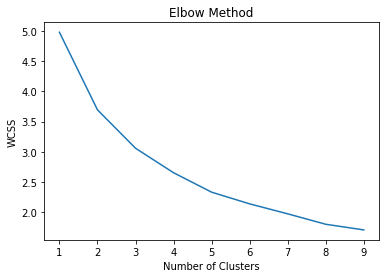

In [432]:
# calculating the Within Cluster Sum of Errors (WCSS) for multiple values of k
wcss = []
kmax=10
for k in np.arange(1,kmax):
    kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 0)
    kmeans.fit(df_activities_clustering)
    wcss.append(kmeans.inertia_)

# Plotting WCSS vs k values
plt.plot(np.arange(1,kmax), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

There isn't an obvious sharp shift. However, it seems that the optimal k might be 2 or 3.

##### Using the Silhouette Method:

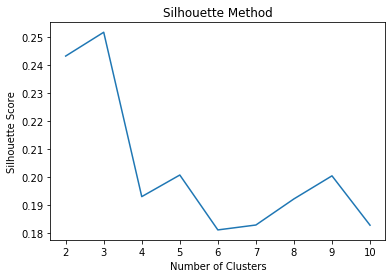

In [433]:
sil = []
kmax = 10
number_of_clusters=np.arange(2, kmax+1)

for k in number_of_clusters:
    kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 0).fit(df_activities_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(df_activities_clustering, labels, metric = 'euclidean'))
    
plt.plot(number_of_clusters, sil)
plt.title("Silhouette Method")
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

The maximum silhouette score occurs at k=3, suggesting that this is the optimal k value.

### Clustering with k=3

In [434]:
# Set number of clusters
kclusters = 3

# Run k-means clustering
kmeans = KMeans(n_clusters=kclusters, init = 'k-means++', random_state=0).fit(df_activities_clustering)

# Check cluster labels generated for each row in the dataframe
kmeans.labels_[0:len(df_activities_clustering)]

array([0, 2, 0, 2, 2, 0, 1, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       2, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 1, 2, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 2, 1, 1, 1, 1, 2, 0, 2, 0, 2, 0, 0, 0, 0,
       0, 1, 1, 0, 2, 2, 1, 1, 2, 0, 2, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 2, 0, 0], dtype=int32)

In [435]:
# Adding cluster labels to df_activity_ratios
df_activity_ratios.insert(0, 'Cluster Labels', kmeans.labels_)
df_activity_ratios.head()

,Cluster Labels,City,Activities,Arts & Ent,Food,Nightlife Spot,Outdoors & Recreation,Shopping
0,0,"Hong Kong, Hong Kong, China",0.350000,0.061224,0.489796,0.122449,0.163265,0.163265
1,2,"Bangkok, Thailand",0.150000,0.000000,0.380952,0.000000,0.190476,0.428571
2,0,"London, United Kingdom",0.392857,0.145455,0.490909,0.127273,0.090909,0.145455
3,2,"Macau, Macau",0.121429,0.058824,0.529412,0.117647,0.176471,0.117647
4,2,"Singapore, Singapore",0.292857,0.073171,0.560976,0.048780,0.268293,0.048780


## VI- Cluster Analysis

In [436]:
print('---- Mean of Ratios by Category ----')
print(df_activity_ratios.iloc[:,[2,3,4,5,6,7]].mean())

for n in np.arange(0,3):
    print('\n---- Mean of Ratios by Category for Cluster {} ----'.format(n))
    print(df_activity_ratios.loc[df_activity_ratios['Cluster Labels']==n,df_activity_ratios.columns[[2,3,4,5,6,7]]].mean())

---- Mean of Ratios by Category ----
Activities               0.297194
Arts & Ent               0.108037
Food                     0.512552
Nightlife Spot           0.091971
Outdoors & Recreation    0.115833
Shopping                 0.171607
dtype: float64

---- Mean of Ratios by Category for Cluster 0 ----
Activities               0.339964
Arts & Ent               0.130926
Food                     0.466005
Nightlife Spot           0.101893
Outdoors & Recreation    0.100728
Shopping                 0.200448
dtype: float64

---- Mean of Ratios by Category for Cluster 1 ----
Activities               0.256098
Arts & Ent               0.080349
Food                     0.632718
Nightlife Spot           0.080660
Outdoors & Recreation    0.077795
Shopping                 0.128478
dtype: float64

---- Mean of Ratios by Category for Cluster 2 ----
Activities               0.212500
Arts & Ent               0.074384
Food                     0.450068
Nightlife Spot           0.075969
Outdoors & Rec

#### Cities in Cluster 0 have more activities than average, although these activities are in the Arts & Entertainment and Shopping categories:

In [437]:
df_activity_ratios.loc[df_activity_ratios['Cluster Labels']==0,df_activity_ratios.columns[[1]]]

,City
0,"Hong Kong, Hong Kong, China"
2,"London, United Kingdom"
5,"Paris, France"
7,"New York City, United States"
8,"Kuala Lumpur, Malaysia"
9,"Istanbul, Turkey"
10,"Delhi, India"
13,"Mumbai, India"
14,"Phuket, Thailand"
15,"Rome, Italy"


#### For activities related to food, one should visit cities in Cluster 1:

In [438]:
df_activity_ratios.loc[df_activity_ratios['Cluster Labels']==1,df_activity_ratios.columns[[1]]]

,City
6,"Dubai, United Arab Emirates"
12,"Shenzhen, China"
17,"Pattaya, Thailand"
19,"Mecca, Saudi Arabia"
20,"Guangzhou, China"
22,"Medina, Saudi Arabia"
23,"Seoul, South Korea"
25,"Agra, India"
26,"Miami, United States"
30,"Ho Chi Minh City, Vietnam"


#### Finally, cities in Cluster 2 are more suited for people looking for outdoorsy activities:

In [439]:
df_activity_ratios.loc[df_activity_ratios['Cluster Labels']==2,df_activity_ratios.columns[[1]]]

,City
1,"Bangkok, Thailand"
3,"Macau, Macau"
4,"Singapore, Singapore"
11,"Antalya, Turkey"
44,"Moscow, Russia"
47,"Ha Long, Vietnam"
56,"Jakarta, Indonesia"
58,"Saint Petersburg, Russia"
60,"Jerusalem, Israel"
64,"Penang Island, Malaysia"


### Visualizing Clusters

In [440]:
df_activity_ratios=pd.merge(df_activity_ratios,df_location_venues,on='City',how='left') # getting geographical coordinates from df_location_venues
df_activity_ratios.drop(columns='Categories',inplace=True)
df_activity_ratios.head(10)

,Cluster Labels,City,Activities,Arts & Ent,Food,Nightlife Spot,Outdoors & Recreation,Shopping,Latitude,Longitude
0,0,"Hong Kong, Hong Kong, China",0.350000,0.061224,0.489796,0.122449,0.163265,0.163265,22.279328,114.162813
1,2,"Bangkok, Thailand",0.150000,0.000000,0.380952,0.000000,0.190476,0.428571,13.753893,100.816080
2,0,"London, United Kingdom",0.392857,0.145455,0.490909,0.127273,0.090909,0.145455,51.507322,-0.127647
3,2,"Macau, Macau",0.121429,0.058824,0.529412,0.117647,0.176471,0.117647,-5.113366,-36.634996
4,2,"Singapore, Singapore",0.292857,0.073171,0.560976,0.048780,0.268293,0.048780,1.357107,103.819499
5,0,"Paris, France",0.407143,0.122807,0.385965,0.105263,0.087719,0.298246,48.856697,2.351462
6,1,"Dubai, United Arab Emirates",0.350000,0.020408,0.693878,0.040816,0.142857,0.102041,25.065700,55.171300
7,0,"New York City, United States",0.385714,0.037037,0.537037,0.074074,0.129630,0.222222,40.712728,-74.006015
8,0,"Kuala Lumpur, Malaysia",0.371429,0.076923,0.557692,0.057692,0.057692,0.250000,3.151664,101.694303
9,0,"Istanbul, Turkey",0.392857,0.109091,0.472727,0.127273,0.218182,0.072727,41.076602,29.052495


In [441]:
# Create map
map_clusters = folium.Map(location=[0,0], zoom_start=2)

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, city, cluster in zip(df_activity_ratios['Latitude'], df_activity_ratios['Longitude'], df_activity_ratios['City'], df_activity_ratios['Cluster Labels']):
    label = folium.Popup(str(city) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters